In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Reglas de evolución del sistema

|          | **Descripción**                   | **Propensidad**                                                                                                                                                          | **Reacción**                                                                               | **Compartimento** |
|----------|-----------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------|-------------------|
| $s_{0}$  | Creación $lasR$                   | $\kappa_{lasR}$                                                                                                                                                          | $lasR\to lasR+1$                                                                             | b                 |
| $s_{1}$  | Degradación $lasR$                | $lasR*\gamma_{lasR}$                                                                                                                                                     | $lasR\to lasR-1$                                                                             | b                 |
| $s_{2}$  | Creación $LasR$                   | $lasR*\kappa_{LasR}$                                                                                                                                                     | $LasR\to LasR+1$                                                                             | b                 |
| $s_{3}$  | Unión $AI_1 + LasR$               | $AI_1*LasR*\mu_{A1{\cdot}LasR}$                                                                                                                                          | $AI_1\to AI_1-1$ <br /> $R\to Las{\cdot}LasR-1$ <br /> $AI_1{\cdot}LasR\to AI_1{\cdot}LasR+1$    | b                 |
| $s_{4}$  | Rompimiento $AI_{1}{\cdot}LasR$   | $AI_{1}{\cdot}LasR*\sigma_{AI1{\cdot}LasR}$                                                                                                                              | $AI_1\to AI_1+1$ <br /> $LasR\to LasR+1$ <br /> $AI_1{\cdot}LasR\to AI_1{\cdot}LasR-1$           | b                 |
| $s_{5}$  | Degradación $LasR$                | $LasR*\gamma_{LasR}$                                                                                                                                                     | $LasR\to LasR-1$                                                                             | b                 |
| $s_{6}$  | Creación $rsaL$                   | $\alpha_{rsaL}+\beta_{rsaL}\frac{K_{1}^{h_{1}}}{(K_{1}^{h_{1}} + LasR{\cdot}AI_1^{h_{1}})}$                                                                              | $rsaL\to rsaL+1$                                                                             | b                 |
| $s_{7}$  | Degradación $rsaL$                | $rsaL*\gamma_{rsaL}$                                                                                                                                                     | $rsaL\to rsaL-1$                                                                             | b                 |
| $s_{8}$  | Creación $RsaL$                   | $rsaL*\kappa_{RsaL}$                                                                                                                                                     | $RsaL\to RsaL+1$                                                                             | b                 |
| $s_{9}$  | Degradación $RsaL$                | $RsaL*\gamma_{RsaL}$                                                                                                                                                     | $RsaL\to RsaL-1$                                                                             | b                 |
| $s_{10}$ | Creación $lasI$                   | $\alpha_{lasI}+\beta_{lasI}\frac{K_{2}^{h_{2}}}{(K_{2}^{h_{2}} + LasR{\cdot}AI_1^{h_{2}})}$ <br /> $+ \beta_{lasI}\frac{K_{3}^{h_{3}}}{(K_{3}^{h_{3}} + RsaL^{h_{3}})}$  | $lasI\to lasI+1$                                                                             | b                 |
| $s_{11}$ | Degradación $lasI$                | $lasI*\gamma_{lasI}$                                                                                                                                                     | $lasI\to lasI-1$                                                                             | b                 |
| $s_{12}$ | Creación $LasI$                   | $lasI*\kappa_{LasI}$                                                                                                                                                     | $LasI\to LasI+1$                                                                             | b                 |
| $s_{13}$ | Degradación $LasI$                | $LasI*\gamma_{LasI}$                                                                                                                                                     | $LasI\to LasI-1$                                                                             | b                 |
| $s_{14}$ | Creación $A1_1$                   | $LasI*\kappa_{AI_1}$                                                                                                                                                     | $A1_1\to A1_1+1$                                                                             | b                 |
| $s_{15}$ | Degradación $A1_1$                | $AI_1*\gamma_{AI_1}$                                                                                                                                                     | $AI_1\to AI_1-1$                                                                             | b                 |
| $s_{16}$ | Difusión $A_1$                    | $AI_1*d$                                                                                                                                                                 | $AI_1\to AI_1-1$ <br /> $AI_{1ext}\to AI_{1ext}+1$                                             | b                 |
| $s_{17}$ | Degradación $AI_{1}{\cdot}LasR$   | $AI_{1}{\cdot}LasR*\gamma_{AI1{\cdot}LasR}$                                                                                                                              | $AI_1{\cdot}LasR\to AI_1{\cdot}LasR-1$                                                       | b                 |
| $s_{18}$ | Difusión $AI_{1ext}$       | $AI_{1ext}*d$                                                                                                                                                                   | $AI_1\to AI_1+1$ <br /> $AI_{1ext}\to AI_{1ext}-1$                                             | e                 |
| $s_{19}$ | Degradación $AI_{1ext}$    | $AI_{1ext}*(\gamma_{A1}+d_{away)}$                                                                                                                                              | $AI_{1ext}\to AI_{1ext}-1$                                                                   | e                 |

In [2]:
def b_rules(x):
    
    lasR, LasR, lasI, LasI, AI1, LasRAI1 = x
    propensities = np.empty(14, dtype=float)
    
    k_lasR = 0.004
    g_lasR = 0.002
    k_LasR = 0.4
    g_LasR = 0.35
    a_lasI = 0.00036
    b_lasI = 0.0058
    K1 = 1.2
    h1 = -1.4
    g_lasI = 0.001
    k_LasI = 0.7
    g_LasI = 0.12
    k_AI1 = 1
    g_AI1 = 0.3
    u_LasRAI1 = 0.05
    s_LasRAI1 = 0.25
    g_LasRAI1 = 0.14
    # Cell parameters
    d = 0.8

    propensities[0] = k_lasR                                                               # + lasR
    propensities[1] = lasR*g_lasR                                                          # - lasR
    propensities[2] = lasR*k_LasR                                                          # + LasR
    propensities[3] = LasRAI1*s_LasRAI1                                                    # + LasR ; + AI1 ; - LasRAI1
    propensities[4] = AI1*LasR*u_LasRAI1                                                   # - LasR ; - AI1 ; + LasRAI1
    propensities[5] = LasR*g_LasR                                                          # - LasR
    propensities[6] = a_lasI + (b_lasI/(1+(LasRAI1/K1)**h1)) if LasRAI1 > 0 else a_lasI    # + lasI
    propensities[7] = lasI*g_lasI                                                          # - lasI
    propensities[8] = lasI*k_LasI                                                          # + LasI
    propensities[9] = LasI*g_LasI                                                          # - LasI
    propensities[10] = LasI*k_AI1                                                          # + AI1
    propensities[11] = AI1*g_AI1                                                           # - AI1
    propensities[12] = d*AI1                                                               # - AI1 ; + AI1_ext
    propensities[13] = LasRAI1*g_LasRAI1                                                   # - LasRAI1

    Stot = propensities.sum()
    U = np.random.rand()
    Tau = np.random.exponential(scale=1/Stot)

    s = 0
    while s < len(propensities):
        if U < propensities[:s+1].sum()/Stot:
            return np.array((Tau, s), dtype=[('tau','f4'), ('j','i4')])
        s += 1

def e_rules(x):
    
    AI1_ext = x
    propensities = np.empty(2, dtype=float)
    
    g_AI1_ext = 0.8
    d = 0.8
    d_away = 1.2
    
    if AI1_ext == 0:                        
        return np.array((0, 99), dtype=[('tau','f4'), ('j','i4')])  # no reaction
    else:
        propensities[0] = AI1_ext*g_AI1_ext      # + AI1 ; - AI1_ext
        propensities[1] = AI1_ext*d_away         # - AI1_ext

        Stot = propensities.sum()
        U = np.random.rand()
        Tau = np.random.exponential(scale=1/Stot)

        s = 0
        while s < len(propensities):
            if U < propensities[:s+1].sum()/Stot:
                return np.array((Tau, 14+s), dtype=[('tau','f4'), ('j','i4')])
            s += 1

In [3]:
def save_bacteria(i, t, bacteria):
    with open('bacteria.tsv', 'a') as bacteria_file:
        bacteria_file.write(f'{i}\t')
        bacteria_file.write(f'{t}\t')
        x = 0
        while x < len(bacteria[i]):
            if x == len(bacteria[i])-1:
                bacteria_file.write(f'{bacteria[i,x]}')
            else:
                bacteria_file.write(f'{bacteria[i,x]}\t')
            x += 1
        bacteria_file.write(f'\n')

def save_environment(t, env):
    with open('environment.tsv', 'a') as env_file:
        env_file.write(f'{t}\t')
        x = 0
        while x < len(env):
            if x == len(env)-1:
                env_file.write(f'{env[x]}')
            else:
                env_file.write(f'{env[x]}\t')
            x += 1
        env_file.write(f'\n')

def waiting_time(reactions_sorted, h):
    if h > 0:
        return reactions_sorted[h]['tau'] - reactions_sorted[h-1]['tau']
    else:
        return reactions_sorted[h]['tau']

In [4]:
N=10

t_max=10000

b_0=np.array([1, 1, 1, 1, 1, 1])

e_0=np.array([0])

b_update = np.array([[1, 0, 0, 0, 0, 0],    # + lasR
                     [-1, 0, 0, 0, 0, 0],   # - lasR
                     [0, 1, 0, 0, 0, 0],    # + LasR
                     [0, 1, 0, 0, 1, -1],   # + LasR ; + AI1 ; - LasRAI1
                     [0,-1, 0, 0, -1, 1],   # - LasR ; - AI1 ; + LasRAI1
                     [0, -1, 0, 0, 0, 0],   # - LasR
                     [0, 0, 1, 0, 0, 0],    # + lasI
                     [0, 0, -1, 0, 0, 0],   # - lasI
                     [0, 0, 0, 1, 0, 0],    # + LasI
                     [0, 0, 0, -1, 0, 0],   # - LasI
                     [0, 0, 0, 0, 1, 0],    # + AI1
                     [0, 0, 0, 0, -1, 0],   # - AI1
                     [0, 0, 0, 0, -1, 0],   # - AI1 ; + AI1_ext
                     [0, 0, 0, 0, 0, -1],   # - LasRAI1
                     [0, 0, 0, 0, 1, 0],    # + AI1 ; - AI1_ext
                     [0, 0, 0, 0, 0, 0]],   # - AI1_ext
            dtype=int)

# e_update = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, -1, -1], dtype=int)
e_update = np.array([[0],   # + lasR
                     [0],   # - lasR
                     [0],   # + LasR
                     [0],   # + LasR ; + AI1 ; - LasRAI1
                     [0],   # - LasR ; - AI1 ; + LasRAI1
                     [0],   # - LasR
                     [0],   # + lasI
                     [0],   # - lasI
                     [0],   # + LasI
                     [0],   # - LasI
                     [0],   # + AI1
                     [0],   # - AI1
                     [+1],  # - AI1 ; + AI1_ext
                     [0],   # - LasRAI1
                     [-1],  # + AI1 ; - AI1_ext
                     [-1]], # - AI1_ext
            dtype=int)

In [5]:
def multicompartmental_gillespie(N, t_max, b_0, e_0, b_update, e_update):
    
    if os.path.exists('bacteria.tsv'):
        os.remove('bacteria.tsv')
    if os.path.exists('environment.tsv'):
        os.remove('environment.tsv')
    
    # Initial conditions
    t = 0

    # Simulation initialization
    bacteria = np.zeros([N, len(b_0)])
    i = 0
    while i < N:
        x = 0
        while x < len(b_0):
            bacteria[i,x] = b_0[x]
            x += 1
        i += 1
    bacteria_file = pd.DataFrame(bacteria, columns=['lasR', 'LasR', 'lasI', 'LasI', 'AI1', 'LasRAI1'])
    bacteria_file.insert(0, 't', np.zeros(N))
    bacteria_file.insert(0, 'cell', np.array(range(N)))
    bacteria_file.set_index('cell', inplace=True)
    bacteria_file.to_csv('bacteria.tsv', sep='\t')
    del bacteria_file

    env = np.zeros(len(e_0))
    x = 0
    while x < len(e_0):
        env[x] = e_0[x]
        x += 1
    env_file = pd.DataFrame(env, columns=['AI1_ext'])
    env_file.insert(0, 't', np.zeros(1))
    env_file.set_index('t', inplace=True)
    env_file.to_csv('environment.tsv', sep='\t')
    del env_file
    
    # Simulation
    while t < t_max:
        reactions = np.zeros(N+1, dtype=[('tau','f4'), ('j','i4'), ('i','i4')])
        i = 0
        while i < N:
            reactions[i]['tau'] = b_rules(bacteria[i])['tau']
            reactions[i]['j'] = b_rules(bacteria[i])['j']
            reactions[i]['i'] = i
            i += 1
        reactions[N]['tau'] = e_rules(env[0])['tau']
        reactions[N]['j'] = e_rules(env[0])['j']
        reactions[N]['i'] = N
        
        reactions_sorted = np.sort(reactions, order='tau')

        h = 0
        while h < N+1:
            if reactions_sorted[h]['i'] == N:
                if reactions_sorted[h]['j'] == 99:
                    h += 1
                    continue
                else:
                    t += waiting_time(reactions_sorted, h)
                    reactions_sorted[h]['tau'] = 0
                    env += e_update[reactions_sorted[h]['j']]
                    save_environment(t, env)
                    if reactions_sorted[h]['j'] == 14:
                        i = np.random.randint(0,N)
                        bacteria[i] += b_update[reactions_sorted[h]['j']]
                        save_bacteria(i, t, bacteria)
                        # Replacement
                        y = 0
                        while y < N+1:
                            if reactions_sorted[y]['i'] == i:
                                if y > h:
                                    reactions_sorted[y]['tau'] = b_rules(bacteria[i])['tau']
                                    reactions_sorted[y]['j'] = b_rules(bacteria[i])['j']
                                    reactions_sorted = np.sort(reactions_sorted, order='tau')
                            y += 1
            
            else:
                t += waiting_time(reactions_sorted, h)
                reactions_sorted[h]['tau'] = 0
                i = reactions_sorted[h]['i']
                bacteria[i] += b_update[reactions_sorted[h]['j']]
                save_bacteria(i, t, bacteria)
                if reactions_sorted[h]['j'] == 12:
                    env += e_update[reactions_sorted[h]['j']]
                    save_environment(t, env)
                    # Replacement
                    y = 0
                    while y < N+1:
                        if reactions_sorted[y]['i'] == N:
                            if y > h:
                                reactions_sorted[y]['tau'] = e_rules(env)['tau']
                                reactions_sorted[y]['j'] = e_rules(env)['j']
                                reactions_sorted = np.sort(reactions_sorted, order='tau')
                        y += 1
                        
            h += 1

    print('Finish')

In [6]:
multicompartmental_gillespie(N, t_max, b_0, e_0, b_update, e_update)

Finish


In [7]:
bacteria = pd.read_table('bacteria.tsv', sep='\t', index_col=0)
bacteria_grouped = [bacteria.loc[i] for i in bacteria.index.unique()]

environment = pd.read_table('environment.tsv', sep='\t', index_col=0)

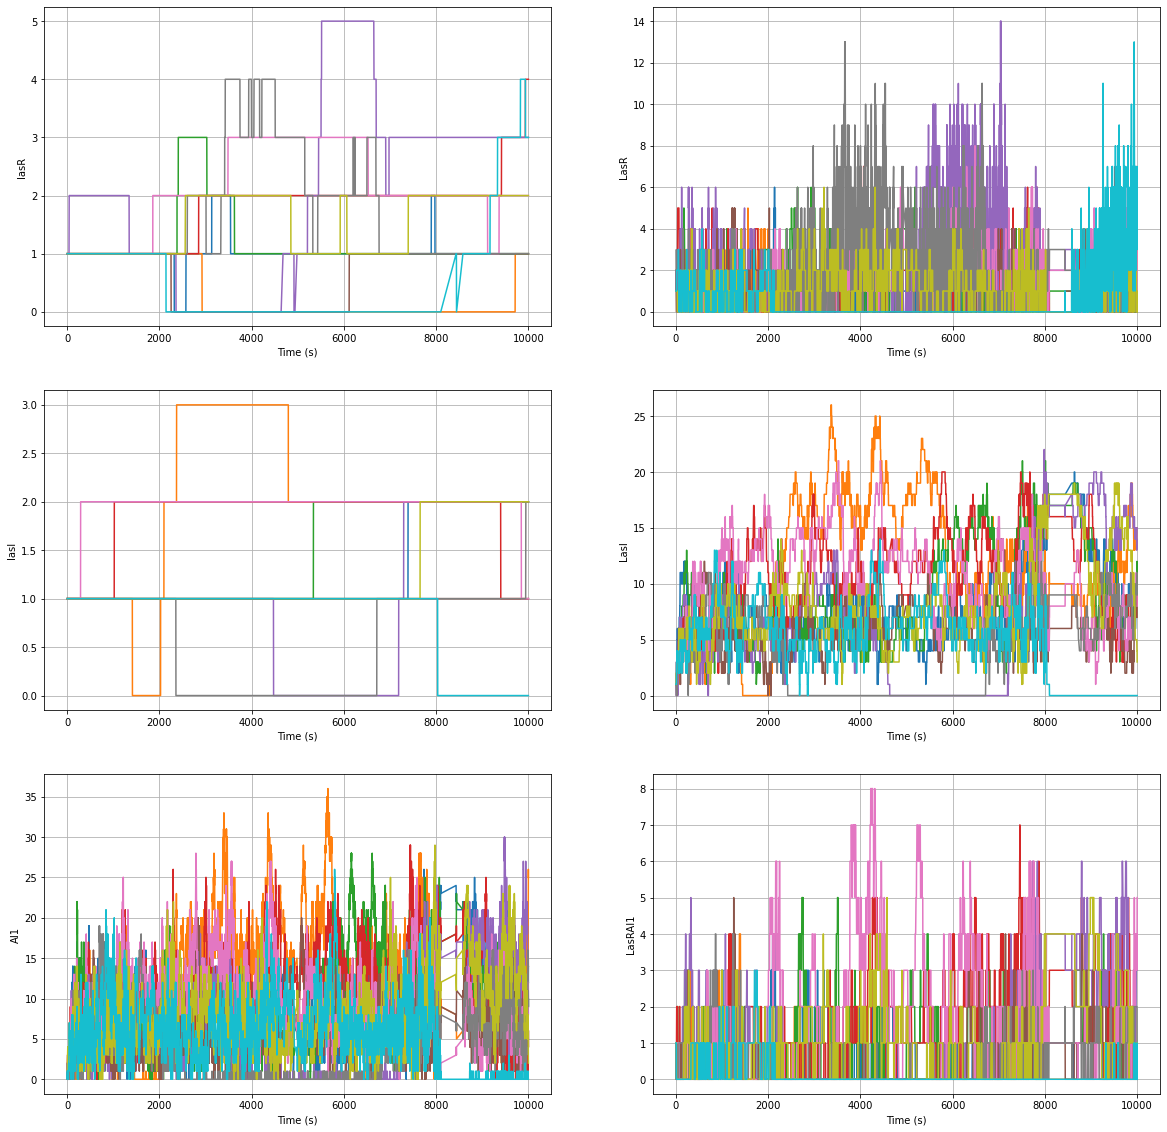

In [8]:
x = ['lasR', 'LasR', 'lasI', 'LasI', 'AI1', 'LasRAI1']
plt.figure(figsize=(20,20))
subplot = 1
for i in x:
    plt.subplot(3,2,subplot)
    for j in bacteria_grouped:
        plt.plot(j['t'], j[i])
    plt.xlabel('Time (s)')
    plt.ylabel(i)
    plt.grid()
    subplot += 1
plt.show()

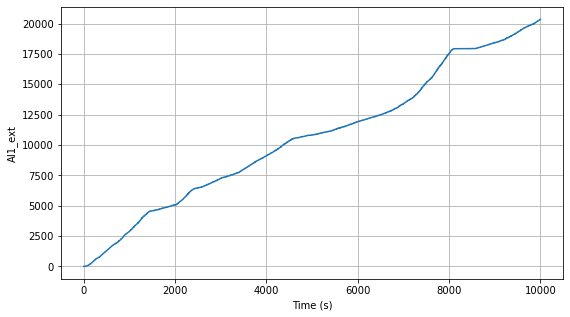

In [9]:
plt.figure(figsize=(9,5))
plt.plot(environment.index, environment['AI1_ext'])
plt.xlabel('Time (s)')
plt.ylabel('AI1_ext')
plt.grid()
plt.show()